In [ ]:
import json
from tqdm.auto import tqdm

from transformers import BertTokenizer
from data_utils import get_examples_from_dialogues, convert_state_dict, load_dataset
from data_utils import OntologyDSTFeature, DSTPreprocessor, _truncate_seq_pair

## Data Loading 

In [2]:
train_data_file = "/opt/ml/input/data/train_dataset/train_dials.json"
slot_meta = json.load(open("/opt/ml/input/data/train_dataset/slot_meta.json"))
ontology = json.load(open("/opt/ml/input/data/train_dataset/ontology.json"))
train_data, dev_data, dev_labels = load_dataset(train_data_file)

In [3]:
train_examples = get_examples_from_dialogues(data=train_data,
                                             user_first=True,
                                             dialogue_level=True)

dev_examples = get_examples_from_dialogues(data=dev_data,
                                           user_first=True,
                                           dialogue_level=True)

100%|██████████| 699/699 [00:00<00:00, 15785.55it/s]


In [4]:
len(train_data)

6301

In [5]:
max_turn = max([len(e['dialogue']) for e in train_data])
tokenizer = BertTokenizer.from_pretrained('dsksd/bert-ko-small-minimal')

## TODO-1: SUMBT Preprocessor 정의 

Ontology-based DST model인 SUMBT의 InputFeature를 만들기 위한 Preprocessor를 정의해야 합니다. <br>

1. `_convert_examples_to_features` 함수의 빈칸을 매워 완성하세요.
2. `recover_state` 함수의 빈칸을 매워 완성하세요.

In [6]:
class SUMBTPreprocessor(DSTPreprocessor):
    def __init__(
        self,
        slot_meta,
        src_tokenizer,
        trg_tokenizer=None,
        ontology=None,
        max_seq_length=64,
        max_turn_length=14,
    ):
        self.slot_meta = slot_meta
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer if trg_tokenizer else src_tokenizer
        self.ontology = ontology
        self.max_seq_length = max_seq_length
        self.max_turn_length = max_turn_length

    def _convert_example_to_feature(self, example):
        guid = example[0].guid.rsplit("-", 1)[0]  # dialogue_idx
        turns = []
        token_types = []
        labels = []
        num_turn = None
        for turn in example[: self.max_turn_length]:
            assert len(turn.current_turn) == 2
            uttrs = []
            for segment_idx, uttr in enumerate(turn.current_turn):
                token = self.src_tokenizer.encode(uttr, add_special_tokens=False)
                uttrs.append(token)

            _truncate_seq_pair(uttrs[0], uttrs[1], self.max_seq_length - 3)
            tokens = (
                [self.src_tokenizer.cls_token_id]
                + uttrs[0]
                + [self.src_tokenizer.sep_token_id]
                + uttrs[1]
                + [self.src_tokenizer.sep_token_id]
            )
            token_type = [0] * (len(uttrs[0]) + 2) + [1] * (len(uttrs[1]) + 1)
            if len(tokens) < self.max_seq_length:
                gap = self.max_seq_length - len(tokens)
                tokens.extend([self.src_tokenizer.pad_token_id] * gap)
                token_type.extend([0] * gap)
            turns.append(tokens)
            token_types.append(token_type)
            label = []
            if turn.label:
                slot_dict = convert_state_dict(turn.label)
            else:
                slot_dict = {}
            for slot_type in self.slot_meta:
                value = slot_dict.get(slot_type, "none")
                # TODO
#                 raise Exception('label_idx를 ontology에서 꺼내오는 코드를 작성하세요!')
                # Your code here!
                if value in self.ontology[slot_type]:
                    label_idx = self.ontology[slot_type].index(value)
                else:
                    label_idx = self.ontology[slot_type].index("none")
                # Your code here!
                label.append(label_idx)
            labels.append(label)
        num_turn = len(turns)
        if len(turns) < self.max_turn_length:
            gap = self.max_turn_length - len(turns)
            for _ in range(gap):
                dummy_turn = [self.src_tokenizer.pad_token_id] * self.max_seq_length
                turns.append(dummy_turn)
                token_types.append(dummy_turn)
                dummy_label = [-1] * len(self.slot_meta)
                labels.append(dummy_label)
        return OntologyDSTFeature(
            guid=guid,
            input_ids=turns,
            segment_ids=token_types,
            num_turn=num_turn,
            target_ids=labels,
        )

    def convert_examples_to_features(self, examples):
        return list(map(self._convert_example_to_feature, examples))

    def recover_state(self, pred_slots, num_turn):
        states = []
        # TODO
#         raise Exception('SUMBT의 아웃풋을 prediction form으로 바꾸는 코드를 작성하세요!')
        # Your code here!
#         for pred_slot in pred_slots[:num_turn]:
#             state=[]
#             for key,val_idx in zip(self.slot_meta,pred_slot):
#                 val=self.ontology[key][val_idx]
#                 if val==0:
#                     continue
#                 state.append(f'{key}-{val}')
#             states.append(state)
#         # Your code here!
#         return states
        for pred_slot in pred_slots[:num_turn]:
            state = []
            for s, p in zip(self.slot_meta, pred_slot):
                v = self.ontology[s][p]
                if v != "none":
                    state.append(f"{s}-{v}")
            states.append(state)
        return states

    def collate_fn(self, batch):
        guids = [b.guid for b in batch]
        input_ids = torch.LongTensor([b.input_ids for b in batch])
        segment_ids = torch.LongTensor([b.segment_ids for b in batch])
        input_masks = input_ids.ne(self.src_tokenizer.pad_token_id)
        target_ids = torch.LongTensor([b.target_ids for b in batch])
        num_turns = [b.num_turn for b in batch]
        return input_ids, segment_ids, input_masks, target_ids, num_turns, guids

## Convert_Examples_to_Features 

In [7]:
processor = SUMBTPreprocessor(slot_meta,
                              tokenizer,
                              ontology=ontology,  # predefined ontology
                              max_seq_length=128,  # 각 turn마다 최대 길이
                              max_turn_length=max_turn)  # 각 dialogue의 최대 turn 길이
train_features = processor.convert_examples_to_features(train_examples)
dev_features = processor.convert_examples_to_features(dev_examples)

In [8]:
print(len(train_features))  # 대화 level의 features
print(len(dev_features))

6301
699


## SUMBT 모델 선언 

In [9]:
"""
Most of code is from https://github.com/SKTBrain/SUMBT
"""

import math
import os.path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CosineEmbeddingLoss, CrossEntropyLoss
from transformers import BertModel, BertPreTrainedModel


class BertForUtteranceEncoding(BertPreTrainedModel):
    def __init__(self, config):
        super(BertForUtteranceEncoding, self).__init__(config)

        self.config = config
        self.bert = BertModel(config)

    def forward(self, input_ids, token_type_ids, attention_mask):
        return self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            output_attentions=False,
            output_hidden_states=False,
            return_dict=False,
        )


class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)

        self.scores = None

    def attention(self, q, k, v, d_k, mask=None, dropout=None):

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)

        if mask is not None:
            mask = mask.unsqueeze(1)
            scores = scores.masked_fill(mask == 0, -1e9)
        scores = F.softmax(scores, dim=-1)

        if dropout is not None:
            scores = dropout(scores)

        self.scores = scores
        output = torch.matmul(scores, v)
        return output

    def forward(self, q, k, v, mask=None):
        bs = q.size(0)

        # perform linear operation and split into h heads
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)

        # transpose to get dimensions bs * h * sl * d_model
        k = k.transpose(1, 2)
        q = q.transpose(1, 2)
        v = v.transpose(1, 2)

        scores = self.attention(q, k, v, self.d_k, mask, self.dropout)

        # concatenate heads and put through final linear layer
        concat = scores.transpose(1, 2).contiguous().view(bs, -1, self.d_model)
        output = self.out(concat)
        return output

    def get_scores(self):
        return self.scores


class SUMBT(nn.Module):
    def __init__(self, args, num_labels, device):
        super(SUMBT, self).__init__()

        self.hidden_dim = args.hidden_dim
        self.rnn_num_layers = args.num_rnn_layers
        self.zero_init_rnn = args.zero_init_rnn
        self.max_seq_length = args.max_seq_length
        self.max_label_length = args.max_label_length
        self.num_labels = num_labels
        self.num_slots = len(num_labels)
        self.attn_head = args.attn_head
        self.device = device

        ### Utterance Encoder
        self.utterance_encoder = BertForUtteranceEncoding.from_pretrained(
            args.model_name_or_path
        )
        self.bert_output_dim = self.utterance_encoder.config.hidden_size
        self.hidden_dropout_prob = self.utterance_encoder.config.hidden_dropout_prob
        if args.fix_utterance_encoder:
            for p in self.utterance_encoder.bert.pooler.parameters():
                p.requires_grad = False

        ### slot, slot-value Encoder (not trainable)
        self.sv_encoder = BertForUtteranceEncoding.from_pretrained(
            args.model_name_or_path
        )
        # os.path.join(args.bert_dir, 'bert-base-uncased.model'))
        for p in self.sv_encoder.bert.parameters():
            p.requires_grad = False

        self.slot_lookup = nn.Embedding(self.num_slots, self.bert_output_dim)
        self.value_lookup = nn.ModuleList(
            [nn.Embedding(num_label, self.bert_output_dim) for num_label in num_labels]
        )

        ### Attention layer
        self.attn = MultiHeadAttention(self.attn_head, self.bert_output_dim, dropout=0)

        ### RNN Belief Tracker
        self.nbt = nn.GRU(
            input_size=self.bert_output_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.rnn_num_layers,
            dropout=self.hidden_dropout_prob,
            batch_first=True,
        )
        self.init_parameter(self.nbt)

        if not self.zero_init_rnn:
            self.rnn_init_linear = nn.Sequential(
                nn.Linear(self.bert_output_dim, self.hidden_dim),
                nn.ReLU(),
                nn.Dropout(self.hidden_dropout_prob),
            )

        self.linear = nn.Linear(self.hidden_dim, self.bert_output_dim)
        self.layer_norm = nn.LayerNorm(self.bert_output_dim)

        ### Measure
        self.metric = torch.nn.PairwiseDistance(p=2.0, eps=1e-06, keepdim=False)

        ### Classifier
        self.nll = CrossEntropyLoss(ignore_index=-1)

        ### Etc.
        self.dropout = nn.Dropout(self.hidden_dropout_prob)

    def initialize_slot_value_lookup(self, label_ids, slot_ids):

        self.sv_encoder.eval()

        # Slot encoding
        slot_type_ids = torch.zeros(slot_ids.size(), dtype=torch.long).to(
            slot_ids.device
        )
        slot_mask = slot_ids > 0
        hid_slot, _ = self.sv_encoder(
            slot_ids.view(-1, self.max_label_length),
            slot_type_ids.view(-1, self.max_label_length),
            slot_mask.view(-1, self.max_label_length),
        )
        hid_slot = hid_slot[:, 0, :]
        hid_slot = hid_slot.detach()
        self.slot_lookup = nn.Embedding.from_pretrained(hid_slot, freeze=True)

        for s, label_id in enumerate(label_ids):
            label_type_ids = torch.zeros(label_id.size(), dtype=torch.long).to(
                label_id.device
            )
            label_mask = label_id > 0
            hid_label, _ = self.sv_encoder(
                label_id.view(-1, self.max_label_length),
                label_type_ids.view(-1, self.max_label_length),
                label_mask.view(-1, self.max_label_length),
            )
            hid_label = hid_label[:, 0, :]
            hid_label = hid_label.detach()
            self.value_lookup[s] = nn.Embedding.from_pretrained(hid_label, freeze=True)
            self.value_lookup[s].padding_idx = -1

        print("Complete initialization of slot and value lookup")
        self.sv_encoder = None

    def forward(
        self,
        input_ids,
        token_type_ids,
        attention_mask,
        labels=None,
        n_gpu=1,
        target_slot=None,
    ):
        # input_ids: [B, M, N]
        # token_type_ids: [B, M, N]
        # attention_mask: [B, M, N]
        # labels: [B, M, J]

        # if target_slot is not specified, output values corresponding all slot-types
        if target_slot is None:
            target_slot = list(range(0, self.num_slots))

        ds = input_ids.size(0)  # Batch size (B)
        ts = input_ids.size(1)  # Max turn size (M)
        bs = ds * ts
        slot_dim = len(target_slot)  # J

        # Utterance encoding
        hidden, _ = self.utterance_encoder(
            input_ids.view(-1, self.max_seq_length),
            token_type_ids.view(-1, self.max_seq_length),
            attention_mask.view(-1, self.max_seq_length),
        )
        hidden = torch.mul(
            hidden,
            attention_mask.view(-1, self.max_seq_length, 1)
            .expand(hidden.size())
            .float(),
        )
        hidden = hidden.repeat(slot_dim, 1, 1)  # [J*M*B, N, H]

        hid_slot = self.slot_lookup.weight[
            target_slot, :
        ]  # Select target slot embedding
        hid_slot = hid_slot.repeat(1, bs).view(bs * slot_dim, -1)  # [J*M*B, N, H]

        # Attended utterance vector
        hidden = self.attn(
            hid_slot,  # q^s  [J*M*B, N, H]
            hidden,  # U [J*M*B, N, H]
            hidden,  # U [J*M*B, N, H]
            mask=attention_mask.view(-1, 1, self.max_seq_length).repeat(slot_dim, 1, 1),
        )
        hidden = hidden.squeeze()  # h [J*M*B, H] Aggregated Slot Context
        hidden = hidden.view(slot_dim, ds, ts, -1).view(
            -1, ts, self.bert_output_dim
        )  # [J*B, M, H]

        # NBT
        if self.zero_init_rnn:
            h = torch.zeros(
                self.rnn_num_layers, input_ids.shape[0] * slot_dim, self.hidden_dim
            ).to(
                self.device
            )  # [1, slot_dim*ds, hidden]
        else:
            h = hidden[:, 0, :].unsqueeze(0).repeat(self.rnn_num_layers, 1, 1)
            h = self.rnn_init_linear(h)

        if isinstance(self.nbt, nn.GRU):
            rnn_out, _ = self.nbt(hidden, h)  # [J*B, M, H_GRU]
        elif isinstance(self.nbt, nn.LSTM):
            c = torch.zeros(
                self.rnn_num_layers, input_ids.shape[0] * slot_dim, self.hidden_dim
            ).to(
                self.device
            )  # [1, slot_dim*ds, hidden]
            rnn_out, _ = self.nbt(hidden, (h, c))  # [slot_dim*ds, turn, hidden]
        rnn_out = self.layer_norm(self.linear(self.dropout(rnn_out)))

        hidden = rnn_out.view(slot_dim, ds, ts, -1)  # [J, B, M, H_GRU]

        # Label (slot-value) encoding
        loss = 0
        loss_slot = []
        pred_slot = []
        output = []
        for s, slot_id in enumerate(target_slot):  ## note: target_slots are successive
            # loss calculation
            hid_label = self.value_lookup[slot_id].weight
            num_slot_labels = hid_label.size(0)

            _hid_label = (
                hid_label.unsqueeze(0)
                .unsqueeze(0)
                .repeat(ds, ts, 1, 1)
                .view(ds * ts * num_slot_labels, -1)
            )
            _hidden = (
                hidden[s, :, :, :]
                .unsqueeze(2)
                .repeat(1, 1, num_slot_labels, 1)
                .view(ds * ts * num_slot_labels, -1)
            )
            _dist = self.metric(_hid_label, _hidden).view(ds, ts, num_slot_labels)
            _dist = -_dist
            _, pred = torch.max(_dist, -1)
            pred_slot.append(pred.view(ds, ts, 1))
            output.append(_dist)

            if labels is not None:
                _loss = self.nll(_dist.view(ds * ts, -1), labels[:, :, s].view(-1))
                loss_slot.append(_loss.item())
                loss += _loss

        pred_slot = torch.cat(pred_slot, 2)
        if labels is None:
            return output, pred_slot

        # calculate joint accuracy
        accuracy = (pred_slot == labels).view(-1, slot_dim)
        acc_slot = (
            torch.sum(accuracy, 0).float()
            / torch.sum(labels.view(-1, slot_dim) > -1, 0).float()
        )
        acc = (
            sum(torch.sum(accuracy, 1) / slot_dim).float()
            / torch.sum(labels[:, :, 0].view(-1) > -1, 0).float()
        )  # joint accuracy

        if n_gpu == 1:
            return loss, loss_slot, acc, acc_slot, pred_slot
        else:
            return (
                loss.unsqueeze(0),
                None,
                acc.unsqueeze(0),
                acc_slot.unsqueeze(0),
                pred_slot.unsqueeze(0),
            )

    @staticmethod
    def init_parameter(module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_normal_(module.weight)
            torch.nn.init.constant_(module.bias, 0.0)
        elif isinstance(module, nn.GRU) or isinstance(module, nn.LSTM):
            torch.nn.init.xavier_normal_(module.weight_ih_l0)
            torch.nn.init.xavier_normal_(module.weight_hh_l0)
            torch.nn.init.constant_(module.bias_ih_l0, 0.0)
            torch.nn.init.constant_(module.bias_hh_l0, 0.0)

## TODO-2: Ontology Pre-Encoding 

Ontology의 slot type들과 이에 속하는 slot_value들을 tokenizing하는 `tokenize_ontology`를 작성하세요. <br>
[CLS] Pooling하여 `slot_lookup` 과 `value_lookup` embedding matrix들을 초기화하는 <br>
`initialize_slot_value_lookup`에 인자로 넘겨주세요. <br>

In [10]:
def tokenize_ontology(ontology, tokenizer, max_seq_length=12):
    # TODO
#     raise Exception('ontology 의 slot, value를 tokenizing하는 코드를 작성하세요!')
    # Your code here!
    slot_types=[]
    slot_values=[]
    for slot, values in ontology.items():
        slot=tokenizer.encode(slot)
        if len(slot) < max_seq_length:
            gap = max_seq_length - len(slot)
            slot.extend([tokenizer.pad_token_id] * gap)
        slot_types.append(slot)
        val_list=[]
        for value in values:
            value=tokenizer.encode(value)
            if len(value) < max_seq_length:
                gap = max_seq_length - len(value)
                value.extend([tokenizer.pad_token_id] * gap)
            val_list.append(value)
        slot_values.append(torch.LongTensor(val_list))
    # Your code here!
    return torch.LongTensor(slot_types), slot_values

In [11]:
# dir(tokenizer)

In [12]:
slot_type_ids, slot_values_ids = tokenize_ontology(ontology, tokenizer, 12)
num_labels = [len(s) for s in slot_values_ids]  # 각 Slot 별 후보 Values의 갯수

print("Tokenized Slot: ", slot_type_ids.size())
for slot, slot_value_id in zip(slot_meta, slot_values_ids):
    print(f"Tokenized Value of {slot}", slot_value_id.size())

Tokenized Slot:  torch.Size([45, 12])
Tokenized Value of 관광-경치 좋은 torch.Size([4, 12])
Tokenized Value of 관광-교육적 torch.Size([4, 12])
Tokenized Value of 관광-도보 가능 torch.Size([4, 12])
Tokenized Value of 관광-문화 예술 torch.Size([4, 12])
Tokenized Value of 관광-역사적 torch.Size([4, 12])
Tokenized Value of 관광-이름 torch.Size([103, 12])
Tokenized Value of 관광-종류 torch.Size([13, 12])
Tokenized Value of 관광-주차 가능 torch.Size([4, 12])
Tokenized Value of 관광-지역 torch.Size([7, 12])
Tokenized Value of 숙소-가격대 torch.Size([5, 12])
Tokenized Value of 숙소-도보 가능 torch.Size([4, 12])
Tokenized Value of 숙소-수영장 유무 torch.Size([4, 12])
Tokenized Value of 숙소-스파 유무 torch.Size([4, 12])
Tokenized Value of 숙소-예약 기간 torch.Size([12, 12])
Tokenized Value of 숙소-예약 명수 torch.Size([12, 12])
Tokenized Value of 숙소-예약 요일 torch.Size([9, 12])
Tokenized Value of 숙소-이름 torch.Size([67, 12])
Tokenized Value of 숙소-인터넷 가능 torch.Size([4, 12])
Tokenized Value of 숙소-조식 가능 torch.Size([4, 12])
Tokenized Value of 숙소-종류 torch.Size([7, 12])
Tokenized Value

## Model 선언 

In [13]:
from argparse import Namespace

args = {
    'hidden_dim': 300,
    'num_rnn_layers': 1,
    'zero_init_rnn': False,
    'max_seq_length': 128,
    'max_label_length': 12,
    'attn_head': 4,
    'fix_utterance_encoder': False,
    'task_name': 'sumbtgru',
    'distance_metric': 'euclidean',
    'model_name_or_path': 'dsksd/bert-ko-small-minimal',
    'warmup_ratio': 0.1,
    'learning_rate': 5e-5,
    'weight_decay': 0.01,
    'num_train_epochs': 10 #원래 10
}

args = Namespace(**args)

num_labels = [len(s) for s in slot_values_ids]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpu = 1 if torch.cuda.device_count() < 2 else torch.cuda.device_count()
n_epochs = args.num_train_epochs

In [14]:
model = SUMBT(args, num_labels, device)
model.initialize_slot_value_lookup(slot_values_ids, slot_type_ids)  # Tokenized Ontology의 Pre-encoding using BERT_SV
model.to(device)
print()

Some weights of the model checkpoint at dsksd/bert-ko-small-minimal were not used when initializing BertForUtteranceEncoding: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForUtteranceEncoding from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForUtteranceEncoding from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at dsksd/bert-ko-small-minimal 

Complete initialization of slot and value lookup



## 데이터 로더 정의

In [15]:
from data_utils import WOSDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
import random


train_data = WOSDataset(train_features)
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, batch_size=4, sampler=train_sampler, collate_fn=processor.collate_fn)

dev_data = WOSDataset(dev_features)
dev_sampler = SequentialSampler(dev_data)
dev_loader = DataLoader(dev_data, batch_size=4, sampler=dev_sampler, collate_fn=processor.collate_fn)

## Optimizer & Scheduler 선언 

In [16]:
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]

t_total = len(train_loader) * n_epochs
optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=int(t_total * args.warmup_ratio), num_training_steps=t_total
)

## TODO-3: Inference code 작성 

In [17]:
from evaluation import _evaluation

In [18]:
def inference(model, eval_loader, processor, device):
    model.eval()
    predictions = {}
    for batch in tqdm(eval_loader):
        input_ids, segment_ids, input_masks, target_ids, num_turns, guids  = \
        [b.to(device) if not isinstance(b, list) else b for b in batch]

        with torch.no_grad():
            _, pred_slot = model(input_ids, segment_ids, input_masks, None, 9)
            
#         for guid, preds, n_turn in zip(guids, pred_slot.tolist(), num_turns):
#             prediction = processor.recover_state(preds, n_turn)

#             for i in range(n_turn):
#                 turn_guid = guid + '-' + str(i)
#                 predictions[turn_guid] = prediction[i]
#     return predictions
        batch_size = input_ids.size(0)
        for i in range(batch_size):
            guid = guids[i]
            states = processor.recover_state(pred_slot.tolist()[i], num_turns[i])
            for tid, state in enumerate(states):
                predictions[f"{guid}-{tid}"] = state
    return predictions

In [19]:
wrong_list=[] #에폭별로 wrong_answer를 담아둘 배열
correct_list=[] #wrong_list의 에폭별 오답률을 위해 correct_answer를 담아둘 배열

## Training 

[0/10] [0/788] 111.170555
[0/10] [100/788] 44.437187
[0/10] [200/788] 43.629490
[0/10] [300/788] 32.353809
[0/10] [400/788] 31.247683
[0/10] [500/788] 22.681833
[0/10] [600/788] 22.234411
[0/10] [700/788] 24.661880



{'joint_goal_accuracy': 0.036546819438956935, 'turn_slot_accuracy': 0.8636551209447303, 'turn_slot_f1': 0.34077969783643214}
[('숙소', 15707), ('식당', 15511), ('관광', 5967), ('택시', 3360), ('지하철', 292)]
[('종류', 6786), ('지역', 6106), ('이름', 5479), ('가격대', 4344), ('예약 요일', 3831)]
[('dontcare', 5602), ('yes', 3471), ('1', 1248), ('서울 중앙', 1237), ('서울 북쪽', 1125)]


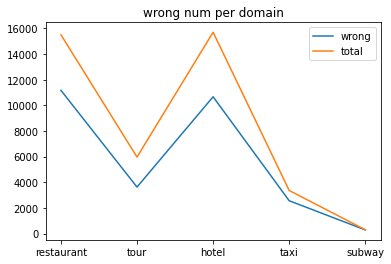

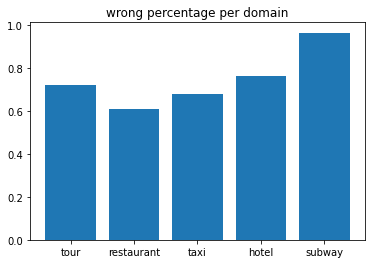

joint_goal_accuracy: 0.036546819438956935
turn_slot_accuracy: 0.8636551209447303
turn_slot_f1: 0.34077969783643214
Update Best checkpoint!
Best checkpoint: /opt/ml/model_ckpt/model-0.bin
score is : 0.036546819438956935
[1/10] [0/788] 17.472647



KeyboardInterrupt: 

In [20]:
from eda import getWrong_Domain_Slot_Value_distribution_counter,getOriginal_Slot_Value_distribution_counter,draw_EDA
from collections import Counter

best_score, best_checkpoint = 0, 0
model_location="/opt/ml/model_ckpt"
best_model=""
for epoch in tqdm(range(n_epochs)):
    batch_loss = []
    model.train()
    for step, batch in enumerate(train_loader):
        input_ids, segment_ids, input_masks, target_ids, num_turns, guids  = \
        [b.to(device) if not isinstance(b, list) else b for b in batch]

        # Forward
        if n_gpu == 1:
            loss, loss_slot, acc, acc_slot, _ = model(input_ids, segment_ids, input_masks, target_ids, n_gpu)
        else:
            loss, _, acc, acc_slot, _ = model(input_ids, segment_ids, input_masks, target_ids, n_gpu)
        
        batch_loss.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        if step % 100 == 0:
            print('[%d/%d] [%d/%d] %f' % (epoch, n_epochs, step, len(train_loader), loss.item()))
    
    #현재 에폭에서의 wrong_list 저장
    predictions = inference(model, dev_loader, processor, device)
    
    # 현재 에폭에서 eval_result 외에도 틀린 예측값, ground truth값을 뽑아낸다
    eval_result,now_wrong_list,now_correct_list = _evaluation(predictions, dev_labels, slot_meta)
    #eda
    
    domain_counter,_,_=getWrong_Domain_Slot_Value_distribution_counter(Counter(now_wrong_list))
    o_domain_counter,_,_=getOriginal_Slot_Value_distribution_counter(Counter(now_correct_list))
    draw_EDA(domain_counter,o_domain_counter)
    
    wrong_list.append(now_wrong_list)
    correct_list.append(now_correct_list)
    for k, v in eval_result.items():
        print(f"{k}: {v}")
        
    if best_score < eval_result['joint_goal_accuracy']:
            print("Update Best checkpoint!")
            best_score = eval_result['joint_goal_accuracy']
            best_checkpoint = epoch

            torch.save(model.state_dict(), f"{model_location}/model-{epoch}.bin")
            best_model=f"{model_location}/model-{epoch}.bin"
    print(f"Best checkpoint: {model_location}/model-{best_checkpoint}.bin")
    print(f"score is : {best_score}")

In [ ]:
#실험코드
from eval_utils import DSTEvaluator
def _evaluation(preds, labels, slot_meta):
    evaluator = DSTEvaluator(slot_meta)

    evaluator.init()
    assert len(preds) == len(labels)
    
    wrong_list=[]
    correct_list=[]
    for k, l in labels.items():
        p = preds.get(k)
        if p is None:
            raise Exception(f"{k} is not in the predictions!")
        evaluator.update(l, p)
        wrong_list.extend(set(l)-set(p))
        correct_list.extend(set(l))
    result = evaluator.compute()
    print(result)
    return result,wrong_list,correct_list
a,b,c=_evaluation(predictions,dev_labels,slot_meta)

In [ ]:
# #prediction의 오답 트랜드 출력
# from eda import getWrong_Domain_Slot_Value_distribution_counter,getOriginal_Slot_Value_distribution_counter,draw_EDA

# getWrong_Domain_Slot_Value_distribution_counter(Counter(wrong_list[0]))
# draw_EDA

## Inference

In [ ]:
eval_data = json.load(open(f"/opt/ml/input/data/eval_dataset/eval_dials.json", "r"))

eval_examples = get_examples_from_dialogues(
    eval_data, user_first=True, dialogue_level=True
)

# Extracting Featrues
eval_features = processor.convert_examples_to_features(eval_examples)
eval_data = WOSDataset(eval_features)
eval_sampler = SequentialSampler(eval_data)
eval_loader = DataLoader(
    eval_data,
    batch_size=5,
    sampler=eval_sampler,
    collate_fn=processor.collate_fn,
)

In [ ]:
predictions = inference(model, eval_loader, processor, device)

In [ ]:
json.dump(predictions, open('predictions2.csv', 'w'), indent=2, ensure_ascii=False) 

In [ ]:
# predictions['square-silence-9151:숙소_관광_11-0']
# for k in dev_labels.keys():
#     if 'square-silence-9151:숙소_관광_11-0' in k:
#         print(k)
#         break
# else :
#     print(1)
# # 'square-silence-9151:숙소_관광_11-0' in dev_labels.keys()
# a='square_111'
# b='asdas_square_111'
# print(b.find(a))

In [ ]:
 ###EDA

In [ ]:
from eda import getWrong_Domain_Slot_Value_distribution_counter,getOriginal_Slot_Value_distribution_counter,draw_EDA
domain_counter,_,_=getWrong_Domain_Slot_Value_distribution_counter(Counter(wrong))
o_domain_counter,_,_getOriginal_Slot_Value_distribution_counter(Counter(dev_labels))
draw_EDA(domain_counter,o_domain_counter)

In [ ]:
subway_list=[]
for k,v in predictions.items():
    if "지하철" in k:
        subway_list.append(k.split(':')[0])

In [ ]:
len(subway_list)

In [ ]:
subway_list[0]

In [ ]:
predictions

In [ ]:
for p,l in zip(predictions.items(),dev_labels.items()):
    if subway_list[0] in p[0] and p[0]==l[0]:
        print(1)
        if set(p[1])!=set(l[1]) :
            print("id",p[0])
            print("pred: ",list(filter(lambda x : '지하철' in x, p[1])))
            print("answr: ",list(filter(lambda x : '지하철' in x, l[1])))
    

In [ ]:
for k,v in dev_labels.items():
    if subway_list[0] in k:
        print("id:",k)
        print(v)

In [ ]:
from matplotlib import pyplot as plt
for epoch, wrong in enumerate(wrong_list):
        if epoch%3==0:
            plt.title('wrong num per domain')
        domain_counter,slot_counter,value_counter=getWrong_Domain_Slot_Value_distribution_counter(Counter(wrong))
        plt.plot(['tour', 'restourant', 'taxi', 'hotel', 'subway'],domain_counter.values(), label=f"ep{epoch} domain")
        if epoch%3==0 and epoch!=0:
            plt.legend()
            plt.show()
plt.legend()
plt.show()